### Limma voom analysis of neurons

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(50))
library(sva)
library(limma)
library(statmod)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-24. For overview type 'help("mgcv-package")'.
Loading required package: genefilter


## Load data and design

In [2]:
##load RNA-seq TPM
data=read.table('atac.counts.txt',header=TRUE,sep='\t')
rownames(data)=paste(data$chrom,data$start,data$end,sep="_")
data$chrom=NULL
data$start=NULL
data$end=NULL

In [3]:
data=data[rowSums(data)>0,]

nrow(data)

[1] 163513

In [4]:
nrow(data)

[1] 163513

In [5]:
head(data)

,excit_rep1,excit_rep2,h1esc_rep1,h1esc_rep2,wtc11_rep1,wtc11_rep2
,<int>,<int>,<int>,<int>,<int>,<int>
chr1_629054_629267,13,5,4052,4489,4564,4747
chr1_629270_629483,731,564,9891,10585,10924,11887
chr1_629601_629976,10222,8715,25275,27402,39880,43029
chr1_630296_630496,332,251,7383,7734,9700,10316
chr1_630697_631477,2256,1870,29200,30948,28516,30763
chr1_631795_632379,1994,1688,24934,26823,21357,23197


In [6]:
#load the metadata
batches=read.table("batches.txt",header=TRUE,sep='\t')
batches$Group=factor(batches$Group)
batches$Rep=factor(batches$Rep)
batches

Rep,Group
<fct>,<fct>
excit_rep1,excit
excit_rep2,excit
h1esc_rep1,h1esc
h1esc_rep2,h1esc
wtc11_rep1,wtc11
wtc11_rep2,wtc11


In [7]:
#use asinh(tpm)
#E=as.matrix(asinh(data))
E=voom(data)$E

## Run PCA 

In [8]:
data.pca=prcomp(t(E))

In [9]:
var_explained=as.character(round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2))

In [10]:
var_explained

[1] "59.01" "21.49" "14.44" "3.54"  "1.51"  "0"

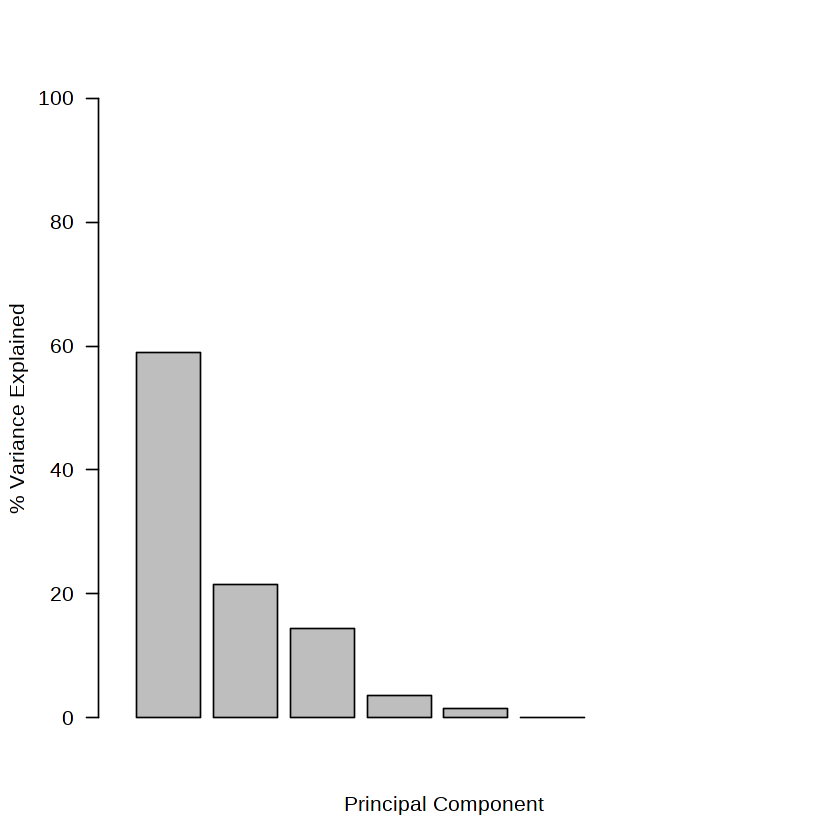

In [11]:
#svg(filename="age_rna_uncorrected_scree.svg",
#   height=3,
#   width=4,
#   pointsize=12)
#print(
    barplot(100*data.pca$sdev^2/sum(data.pca$sdev^2),las=2,ylab="% Variance Explained",xlab="Principal Component",ylim=c(0,100), xlim=c(0,10))#)
#dev.off() 

In [12]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)
#pca_df$Day=factor(pca_df$Day)

In [13]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,Rep,Group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
excit_rep1,-498.9031,97.95583,206.471524,0.4579326,0.51022240,4.942966e-12,excit_rep1,excit
excit_rep2,-321.2249,-18.15558,-290.667648,2.3506027,-0.06296758,4.747813e-12,excit_rep2,excit
h1esc_rep1,275.8440,193.89935,-7.214294,0.1572060,83.21432746,-2.122495e-12,h1esc_rep1,h1esc
h1esc_rep2,272.4542,196.21007,-6.037442,0.5680802,-83.12834205,-3.531815e-12,h1esc_rep2,h1esc
wtc11_rep1,140.8880,-238.78349,51.731486,125.4858894,-0.13650925,-2.438629e-12,wtc11_rep1,wtc11
wtc11_rep2,130.9417,-231.12618,45.716375,-129.0197109,-0.39673098,-1.594187e-12,wtc11_rep2,wtc11


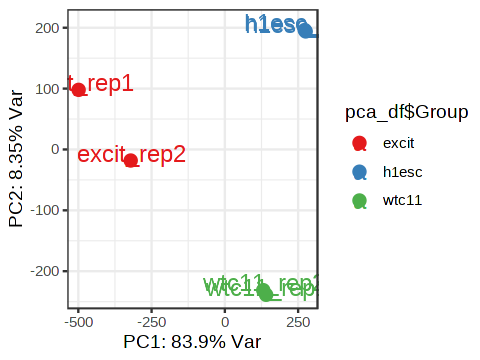

In [14]:
#svg(filename="age_rna_uncorrected_PC1_vs_PC2_batch.svg",
#   height=8,
#   width=8,
#   pointsize=12)
#print(
options(repr.plot.width=4, repr.plot.height=3)
    ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Group,label=pca_df$Rep))+
geom_point(size=3)+
geom_text(nudge_x=2,nudge_y = 12,size=5)+
scale_color_manual(values=c('#e41a1c','#377eb8','#4daf4a'))+
theme_bw()+
xlab("PC1: 83.9% Var")+
ylab("PC2: 8.35% Var")
#dev.off() 

In [15]:
#fit <- lmFit(E,full.design.sv)
fit = lmFit(E,model.matrix(~0+Group,data=batches))

In [16]:
colnames(fit)


[1] "Groupexcit" "Grouph1esc" "Groupwtc11"

In [17]:
colnames(fit$coefficients)

[1] "Groupexcit" "Grouph1esc" "Groupwtc11"

###  Contrasts 

In [18]:
#create contrasts of interest 
cont.matrix=makeContrasts(
    excit_vs_wtc11="Groupexcit - Groupwtc11",  
    excit_vs_h1esc="Groupexcit - Grouph1esc",
    h1esc_vs_wtc11="Grouph1esc - Groupwtc11",
    levels=model.matrix(~0+Group,data=batches))


In [19]:
pval_thresh=0.01
lfc_thresh=1

In [20]:
fit2=contrasts.fit(fit,cont.matrix)
e=eBayes(fit2)
comparisons=colnames(cont.matrix)

In [21]:
for(i in seq(1,length(comparisons)))
{
  tab<-topTable(e, number=nrow(e),coef=i,lfc=lfc_thresh, p.value = pval_thresh)
  up=sum(tab$logFC> 0)
  down=sum(tab$logFC< 0)
  sig=nrow(tab)
  curtitle=paste(comparisons[i],'\n','sig:',sig,'\n','up:',up,'\n','down:',down,'\n')
  print(curtitle)
  vals=topTable(e,number=nrow(e),coef=i)
  vals$pscaled=-1*log10(vals$adj.P.Val)
  vals$sig=vals$adj.P.Val<pval_thresh & abs(vals$logFC)>lfc_thresh 
  png(paste("volcano_diff",comparisons[i],".png",sep=""))
  print(ggplot(data=vals,
               aes(y=vals$pscaled,x=vals$logFC,color=vals$sig))+
               geom_point(alpha=0.1)+
               xlab("log2(FC)")+
               ylab("-log10(pval)")+
               ggtitle(curtitle)+
               theme_bw()+
               scale_color_manual(values=c("#000000","#FF0000")))
  dev.off() 
  write.table(tab,file=paste("diff_",comparisons[i],".tsv",sep=""),quote=FALSE,sep='\t',row.names = TRUE,col.names = TRUE)
}
    

[1] "excit_vs_wtc11 \n sig: 3884 \n up: 545 \n down: 3339 \n"
[1] "excit_vs_h1esc \n sig: 17754 \n up: 5369 \n down: 12385 \n"
[1] "h1esc_vs_wtc11 \n sig: 0 \n up: 0 \n down: 0 \n"
